<b>#-----------------------------------------Healthcare dataset -----------------------------------------------#</b>

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

<b>#########################################DATA CLEANING##########################################</b>

<b>--------------------------------Import Libraries------------------------------</b>

In [90]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from sklearn.utils import resample

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,classification_report,roc_curve,plot_roc_curve,auc,precision_recall_curve,plot_precision_recall_curve,average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

<b>-------------------------------Imputer Function Defintions-----------------------------</b>

In [91]:
def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

def imputation(df1 , cols):
    df = df1.copy()
    
    #Add MApping
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mapStore[variable] = mappings
        
    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mapStore[variable]) 
        
    #Minmaxscaler and KNN imputation 
    sca = minMaxScaler.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = minMaxScaler.inverse_transform(knn)
    for col in cols : 
        df[col] = round(df[col]).astype('int')
    return df

def mapCategories(df, cols):
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mapStore[variable] = mappings

def unMapCategories(df, cols):
    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mapStore[i].items()}
        df[i] = df[i].map(inv_map)
    return df

def encodeCategoryFeature(df:pd.DataFrame, label:str):
    from sklearn.preprocessing import LabelEncoder
    lbl = LabelEncoder() # init label encoder
    y_lbl = lbl.fit_transform(df[label]) # encode target variable
    label_map = dict(zip(df[label], y_lbl)) # get the mapping between the original labels and encoded labels
    df[label] = y_lbl
    return label_map

def decodeDataFrame(df, cols):
    df1 = df.copy()
    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mapStore[i].items()}
        df1[i] = df1[i].map(inv_map)
    return df1

<b>----------------------Data Loading--------------------------</b>

In [92]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv') 

mapStore = dict()
minMaxScaler = MinMaxScaler()

<b>----------------------Clean & Remove Unwanted Values--------------------------</b>

In [93]:
# ------------------------Gender ----------------------------#
# 1. There were 1 patients who were categorized as ‘Other’ in the gender column. 
# 2. They were dropped because their size was insignificant to the dataset 
genderRows = df[df['gender'] == 'Other'].index 
df.drop(genderRows, inplace=True)

<b>----------------Encode & Map Category Features-------------------------</b>

In [94]:
label_map = encodeCategoryFeature(df, label='gender')
mapStore['gender'] = label_map

label_map = encodeCategoryFeature(df, label='ever_married')
mapStore['ever_married'] = label_map

label_map = encodeCategoryFeature(df, label='work_type')
mapStore['work_type'] = label_map

label_map = encodeCategoryFeature(df, label='Residence_type')
mapStore['Residence_type'] = label_map

In [42]:
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,formerly smoked,1
1,51676,0,61.0,0,0,1,3,0,202.21,NaN,never smoked,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,never smoked,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,smokes,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,never smoked,1
5,56669,1,81.0,0,0,1,2,1,186.21,29.0,formerly smoked,1
6,53882,1,74.0,1,1,1,2,0,70.09,27.4,never smoked,1
7,10434,0,69.0,0,0,0,2,1,94.39,22.8,never smoked,1
8,27419,0,59.0,0,0,1,2,0,76.15,NaN,Unknown,1
9,60491,0,78.0,0,0,1,2,1,58.57,24.2,Unknown,1


<b>----------------Fix Categorical Features Values------------------------------</b>

In [95]:
#Convert smoking_status 'unknown' as N/A
df['smoking_status'].mask(df['smoking_status'] == 'Unknown', np.nan, inplace=True)

<b>-----------------------Missing Values (BMI)----------------------------------</b>

In [96]:
mean_value = df['bmi'].mean()
df['bmi'].fillna(mean_value, inplace = True)

<b>-----------------------Missing Values (Smoking Status)--------------------------------------</b>

In [97]:
# Impute Smoking Status with KNN Algo
df=imputation(df,['smoking_status'])

In [11]:
mapStore

{'gender': {'Male': 1, 'Female': 0},
 'ever_married': {'Yes': 1, 'No': 0},
 'work_type': {'Private': 2,
  'Self-employed': 3,
  'Govt_job': 0,
  'children': 4,
  'Never_worked': 1},
 'Residence_type': {'Urban': 1, 'Rural': 0},
 'smoking_status': {'formerly smoked': 0, 'never smoked': 1, 'smokes': 2}}

In [47]:
#Check for any null values 
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [98]:
#Get Original Dataset - Run only once - Horrible Bug 
dfEncoded = decodeDataFrame(df, ['smoking_status', 'gender', 'ever_married', 'work_type', 'Residence_type'])
dfEncoded.head(20)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046.0,Male,67.0,0.0,1.0,Yes,Private,Urban,228.69,36.60000,formerly smoked,1.0
1,51676.0,Female,61.0,0.0,0.0,Yes,Self-employed,Rural,202.21,28.89456,never smoked,1.0
2,31112.0,Male,80.0,0.0,1.0,Yes,Private,Rural,105.92,32.50000,never smoked,1.0
3,60182.0,Female,49.0,0.0,0.0,Yes,Private,Urban,171.23,34.40000,smokes,1.0
4,1665.0,Female,79.0,1.0,0.0,Yes,Self-employed,Rural,174.12,24.00000,never smoked,1.0
5,56669.0,Male,81.0,0.0,0.0,Yes,Private,Urban,186.21,29.00000,formerly smoked,1.0
6,53882.0,Male,74.0,1.0,1.0,Yes,Private,Rural,70.09,27.40000,never smoked,1.0
7,10434.0,Female,69.0,0.0,0.0,No,Private,Urban,94.39,22.80000,never smoked,1.0
8,27419.0,Female,59.0,0.0,0.0,Yes,Private,Rural,76.15,28.89456,never smoked,1.0
9,60491.0,Female,78.0,0.0,0.0,Yes,Private,Urban,58.57,24.20000,formerly smoked,1.0


In [13]:
# Did KnnImpute work well ?
dfEncoded.loc[(df['id'] == 27419) | (df['id'] == 32257) | (df['id'] == 17739) | (df['id'] == 16934) | (df['id'] == 54921) ]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
8,27419.0,Female,59.0,0.0,0.0,Yes,Private,Rural,76.15,28.89456,never smoked,1.0
208,54921.0,Male,78.0,1.0,0.0,Yes,Self-employed,Rural,134.80,33.60000,never smoked,1.0
244,17739.0,Male,57.0,0.0,0.0,Yes,Private,Rural,84.96,36.70000,formerly smoked,1.0
254,32257.0,Female,47.0,0.0,0.0,Yes,Private,Urban,210.95,50.10000,never smoked,0.0
334,16934.0,Female,51.0,0.0,0.0,Yes,Self-employed,Rural,89.84,29.90000,never smoked,0.0


<b>#######################################DATA REDUCTION##############################################</b>

<b>--------------------------Remove Non Critical Columns----------------------------</b>

In [99]:
#Remove Id 
df.drop(columns=['id'], inplace=True)

<b>--------------------------Remove Columns with Lower Correlations----------------------------</b>

In [53]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,67.0,0.0,1.0,1.0,2.0,1.0,228.69,36.60000,0,1.0
1,0.0,61.0,0.0,0.0,1.0,3.0,0.0,202.21,28.89456,1,1.0
2,1.0,80.0,0.0,1.0,1.0,2.0,0.0,105.92,32.50000,1,1.0
3,0.0,49.0,0.0,0.0,1.0,2.0,1.0,171.23,34.40000,2,1.0
4,0.0,79.0,1.0,0.0,1.0,3.0,0.0,174.12,24.00000,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5105,0.0,80.0,1.0,0.0,1.0,2.0,1.0,83.75,28.89456,1,0.0
5106,0.0,81.0,0.0,0.0,1.0,3.0,1.0,125.20,40.00000,1,0.0
5107,0.0,35.0,0.0,0.0,1.0,3.0,0.0,82.99,30.60000,1,0.0
5108,1.0,51.0,0.0,0.0,1.0,2.0,0.0,166.29,25.60000,0,0.0


<AxesSubplot:>

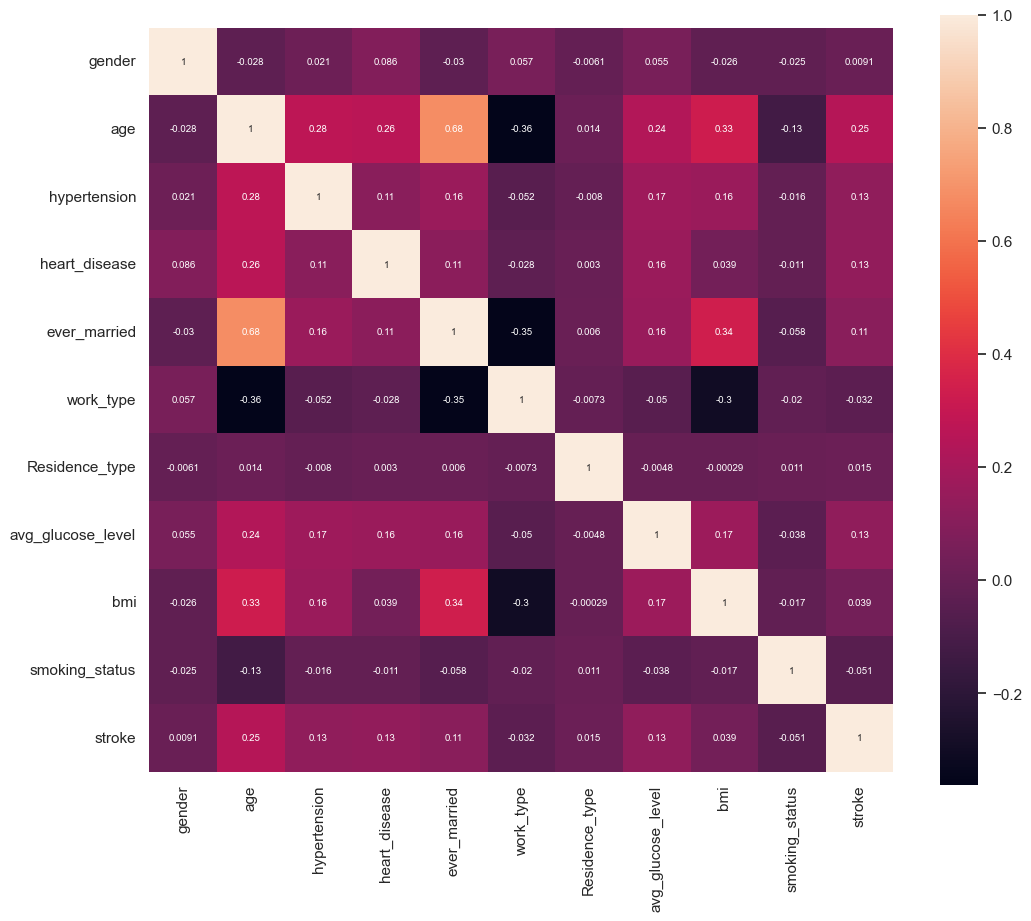

In [100]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
heart_stroke_corr = df.corr()
sns.heatmap(heart_stroke_corr,xticklabels=heart_stroke_corr.columns, yticklabels=heart_stroke_corr.columns, annot=True, annot_kws={"size": 7}, square=True)

In [101]:
df['stroke'].value_counts()

0.0    4860
1.0     249
Name: stroke, dtype: int64

In [102]:
# Remove Columns that have negative correlation
df.drop(columns=['gender'], inplace=True)
df.drop(columns=['work_type'], inplace=True)
df.drop(columns=['Residence_type'], inplace=True)

# bmi & smoking status though has negative or low correlation, it needs to be imvestigated
# Todo : Data Visualization References need to be brought in for analysis of bmi and smoking_status
#df.drop(columns=['bmi'], inplace=True)
#df.drop(columns=['smoking_status'], inplace=True)

<b>#######################################DATA SCALING##############################################</b>

In [17]:
# Standard Deviation for age, avg_glucose_level, bmi is very apart 
df.describe()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,0.656293,106.140399,28.894560,0.976121,0.048738
std,22.613575,0.296633,0.226084,0.474991,45.285004,7.698235,0.591490,0.215340
min,0.080000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,77.240000,23.800000,1.000000,0.000000
50%,45.000000,0.000000,0.000000,1.000000,91.880000,28.400000,1.000000,0.000000
75%,61.000000,0.000000,0.000000,1.000000,114.090000,32.800000,1.000000,0.000000
max,82.000000,1.000000,1.000000,1.000000,271.740000,97.600000,2.000000,1.000000


In [103]:
# apply Scaling- Standardization 

# numerical features
num_cols = ['age','avg_glucose_level', 'bmi']

# apply standardization on numerical features
for col in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(df[[col]])
    
    # transform the training data column
    df[col] = scale.transform(df[[col]])

In [68]:
# Check Post Scaled Values
df.describe()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke
count,5.109000e+03,5109.000000,5109.000000,5109.000000,5.109000e+03,5.109000e+03,5109.000000,5109.000000
mean,3.077275e-16,0.097475,0.054022,0.656293,-1.407717e-16,-2.748829e-16,0.976121,0.048738
std,1.000098e+00,0.296633,0.226084,0.474991,1.000098e+00,1.000098e+00,0.591490,0.215340
min,-1.908332e+00,0.000000,0.000000,0.000000,-1.126761e+00,-2.415668e+00,0.000000,0.000000
25%,-8.062312e-01,0.000000,0.000000,0.000000,-6.382516e-01,-6.618476e-01,1.000000,0.000000
50%,7.827984e-02,0.000000,0.000000,1.000000,-3.149342e-01,-6.424957e-02,1.000000,0.000000
75%,7.858887e-01,0.000000,0.000000,1.000000,1.755632e-01,5.073659e-01,1.000000,0.000000
max,1.714625e+00,1.000000,1.000000,1.000000,3.657189e+00,8.925704e+00,2.000000,1.000000


<b>#######################################DATA TRANSFORMATION##############################################</b>

<b>------------------------------Apply Correlations to drop Low Correlations---------------------------------</b>

In [104]:
# Checking Effective Correlation
classifier = SelectKBest(score_func=f_classif,k=5)
fits = classifier.fit(df.drop('stroke',axis=1),df['stroke'])
x=pd.DataFrame(fits.scores_)
columns = pd.DataFrame(df.drop('stroke',axis=1).columns)
fscores = pd.concat([columns,x],axis=1)
fscores.columns = ['Attribute','Score']
fscores.sort_values(by='Score',ascending=False)

,Attribute,Score
0,age,326.799849
2,heart_disease,94.666779
4,avg_glucose_level,90.550026
1,hypertension,84.919947
3,ever_married,60.609558
6,smoking_status,13.215742
5,bmi,7.746392


In [105]:
#age is a highly correlated variable and then it gets decreasing. I am keeping the threshold score as 50
cols=fscores[fscores['Score']>50]['Attribute']
print(cols)

0                  age
1         hypertension
2        heart_disease
3         ever_married
4    avg_glucose_level
Name: Attribute, dtype: object


In [106]:
# Retain Top Features with Score > 50, drop the Rest
df.drop(columns=['smoking_status'], inplace=True)
df.drop(columns=['bmi'], inplace=True)

<b>-----------------------------------Separate Dependent and Independent Variables ( Features )-----------------------------------</b>

In [72]:
# Look up current Dataset
df

,age,hypertension,heart_disease,ever_married,avg_glucose_level,stroke
0,1.051242,0.0,1.0,1.0,2.706450,1.0
1,0.785889,0.0,0.0,1.0,2.121652,1.0
2,1.626174,0.0,1.0,1.0,-0.004867,1.0
3,0.255182,0.0,0.0,1.0,1.437473,1.0
4,1.581949,1.0,0.0,1.0,1.501297,1.0
...,...,...,...,...,...,...
5105,1.626174,1.0,0.0,1.0,-0.494481,0.0
5106,1.670400,0.0,0.0,1.0,0.420922,0.0
5107,-0.363976,0.0,0.0,1.0,-0.511266,0.0
5108,0.343633,0.0,0.0,1.0,1.328375,0.0


In [107]:
# X and Y Splitting
x = df.iloc[:,0:-1].values
y = df.iloc[:,-1].values

print('X Shape', x.shape)
print('Y Shape',y.shape)

X Shape (5109, 5)
Y Shape (5109,)


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                5109 non-null   float64
 1   hypertension       5109 non-null   float64
 2   heart_disease      5109 non-null   float64
 3   ever_married       5109 non-null   float64
 4   avg_glucose_level  5109 non-null   float64
 5   stroke             5109 non-null   float64
dtypes: float64(6)
memory usage: 279.4 KB


<b>---------------------------Split Data as Training and Testing Data Models--------------------------</b>

In [108]:
# Train Test Split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

print('Number transations x_train df',X_train.shape)
print('Number transations x_test df',X_test.shape)
print('Number transations y_train df',y_train.shape)
print('Number transations y_test df',y_test.shape)

Number transations x_train df (4087, 5)
Number transations x_test df (1022, 5)
Number transations y_train df (4087,)
Number transations y_test df (1022,)


<b>---------------------------Smote Analysis - Handle Imbalanced Data--------------------------</b>

In [109]:
print('Before OverSampling, counts of label 1: {}'.format(sum(y_train==1)))
print('Before OverSampling, counts of label 0: {} \n'.format(sum(y_train==0)))

Before OverSampling, counts of label 1: 195
Before OverSampling, counts of label 0: 3892 



In [110]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train,y_train.ravel())

print('After OverSampling, the shape of train_x: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_train_res.shape))

print('After OverSampling, counts of label 1: {}'.format(sum(y_train_res == 1)))
print('After OverSampling, counts of label 0: {}'.format(sum(y_train_res == 0)))

After OverSampling, the shape of train_x: (7784, 5)
After OverSampling, the shape of train_y: (7784,)
After OverSampling, counts of label 1: 3892
After OverSampling, counts of label 0: 3892


In [26]:
X_train_res

array([[ 0.69743758,  0.        ,  1.        ,  1.        ,  1.96198055],
       [-1.1158101 ,  0.        ,  0.        ,  0.        , -0.09254299],
       [ 1.40504644,  0.        ,  0.        ,  1.        , -0.60379978],
       ...,
       [ 0.77306003,  0.        ,  1.        ,  1.        , -0.00220762],
       [ 0.68655068,  0.        ,  0.        ,  1.        ,  1.91711145],
       [ 0.63309601,  0.        ,  0.        ,  1.        ,  1.82501064]])

In [28]:
y_train_res

array([0., 0., 1., ..., 1., 1., 1.])

<b>#######################################MODEL TRAINING AND TESTING##############################################</b>

In [111]:
models = []
models.append(['XGBClassifier',XGBClassifier(learning_rate=0.1,objective='binary:logistic',random_state=0,eval_metric='mlogloss')])
models.append(['Logistic Regression',LogisticRegression(random_state=0)])
models.append(['SVM',SVC(random_state=0)])
models.append(['KNeigbors',KNeighborsClassifier()])
models.append(['GaussianNB',GaussianNB()])
models.append(['BernoulliNB',BernoulliNB()])
models.append(['DecisionTree',DecisionTreeClassifier(random_state=0)])
models.append(['RandomForest',RandomForestClassifier(random_state=0)])
models.append(['AdaBoostClassifier',AdaBoostClassifier()])

In [112]:
lst_1 = []
for m in range(len(models)):
    lst_2 = []
    model = models[m][1]
    model.fit(X_train_res,y_train_res)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracies = cross_val_score(estimator= model, X = X_train_res,y = y_train_res, cv=10)

# k-fOLD Validation
    roc = roc_auc_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    lst_2.append(models[m][0])
    lst_2.append(accuracy_score(y_test,y_pred)*100)
    lst_2.append(accuracies.mean()*100)
    lst_2.append(accuracies.std()*100)
    lst_2.append(roc)
    lst_2.append(precision)
    lst_2.append(recall)
    lst_2.append(f1)
    lst_1.append(lst_2)

In [113]:
df2 = pd.DataFrame(lst_1,columns=['Model','Accuracy','K-Fold Mean Accuracy','Std.Deviation','ROC_AUC','Precision','Recall','F1 Score'])

df2.sort_values(by=['Accuracy','K-Fold Mean Accuracy'],inplace=True,ascending=False)
df2

,Model,Accuracy,K-Fold Mean Accuracy,Std.Deviation,ROC_AUC,Precision,Recall,F1 Score
0,XGBClassifier,90.508806,92.523867,3.596683,0.530246,0.109091,0.111111,0.110092
6,DecisionTree,88.943249,91.894130,4.055887,0.548209,0.116883,0.166667,0.137405
7,RandomForest,88.062622,91.020061,1.478971,0.561046,0.122222,0.203704,0.152778
3,KNeigbors,80.821918,85.932330,1.162403,0.636478,0.126316,0.444444,0.196721
2,SVM,75.929550,78.789744,1.296793,0.741793,0.144444,0.722222,0.240741
8,AdaBoostClassifier,75.636008,79.881877,1.111172,0.696530,0.129278,0.629630,0.214511
1,Logistic Regression,75.538160,77.453511,1.656623,0.730984,0.139706,0.703704,0.233129
4,GaussianNB,74.559687,76.477341,1.642466,0.743304,0.139860,0.740741,0.235294
5,BernoulliNB,57.045010,72.700252,1.474918,0.712045,0.098121,0.870370,0.176360


<b>####################################Model Evaluation##########################################</b>

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       968
         1.0       0.11      0.11      0.11        54

    accuracy                           0.91      1022
   macro avg       0.53      0.53      0.53      1022
weighted avg       0.91      0.91      0.91      1022

ROC AUC score: 0.7708237679828589
Accuracy Score:  0.9050880626223092


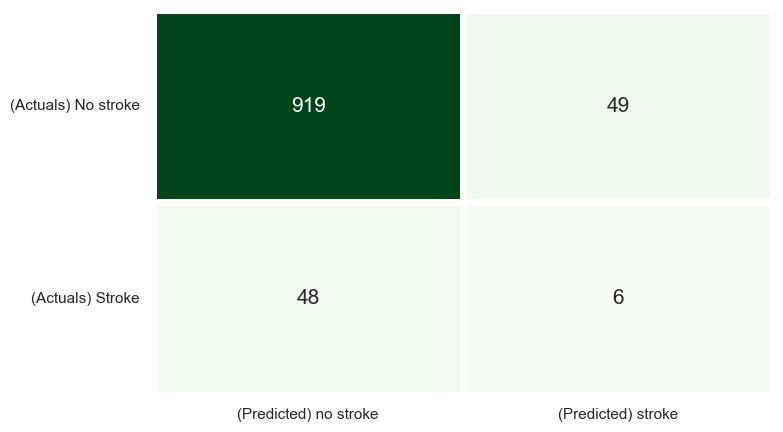

In [114]:
classifier = XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))

# Visualizing Confusion Matrix
#plt.title('Confusion matrix for random forest')
#plt.ylabel('Actuals')
#plt.xlabel('Predicted')
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Greens', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['(Actuals) No stroke', '(Actuals) Stroke'], xticklabels = ['(Predicted) no stroke', '(Predicted) stroke'])
plt.yticks(rotation = 0)
plt.show()

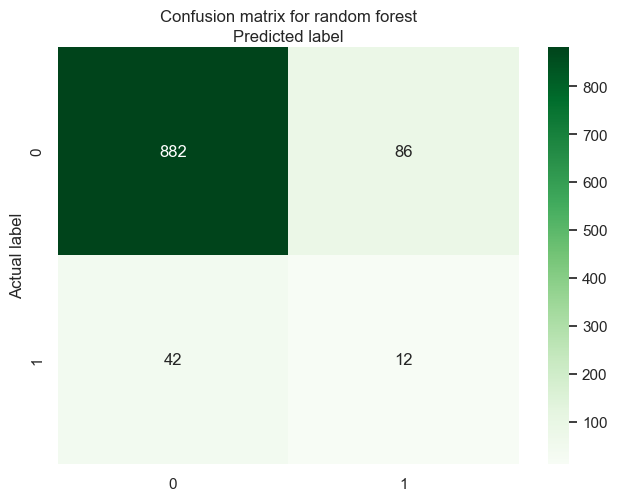

In [115]:
confusion_matrix = confusion_matrix(y_test,Y_pred)
class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
sns.heatmap(pd.DataFrame(confusion_matrix), annot = True, cmap = 'Greens', fmt = 'g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix for random forest')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()